In [2]:
import sys, os, glob
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib
matplotlib.use('TkAgg')
from matplotlib import pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

sys.path.append('../src/')
from training import train_spotwise, train_gridwise
from count_datasets import load_count_dataset, load_count_grid_dataset, read_annotated_starray
from count_datasets import CountDataset, CountGridDataset

from scanpy.pp import highly_variable_genes
from anndata import AnnData

In [3]:
# Find highly variable genes according to the method of Seurat_V3, which operates on (raw) count data.
# - z-score normalization performed per feature (gene)
# - calculate variance of each gene after normalization, return genes w/highest values

data_dir = os.path.expanduser('~/Documents/Splotch_projects/Maynard_DLPFC/data/')

X = []
files, coords = [],[]

for cfile in glob.glob(os.path.join(data_dir, 'Countfiles_Visium', '*.unified.tsv')):
    count_dat = pd.read_csv(cfile, sep='\t', header=0, index_col=0)
    X.append(count_dat.values.T)
    
    coords += list(count_dat.columns)
    files += [Path(cfile).name] * len(count_dat.columns)
X = np.vstack(X)

var = pd.DataFrame(index=count_dat.index)
obs = pd.DataFrame({'st_file': files, 'st_coord': coords})

adata = AnnData(X, obs=obs, var=var)

highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=2150)

/Users/adaly/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
# See which of Joana's marker genes are included in the set of automatically-derived HVGs
jp_markers = {
    'MBP': 'ENSG00000197971',    # WM
    'SNAP25': 'ENSG00000132639', # GM (Layers 1-6)
    'PCP4': 'ENSG00000183036',   # Layer 5
    'RORB': 'ENSG00000198963',   # Layer 4
    'SYNPR': 'ENSG00000163630',  # Layer 6
    'MFGE8': 'ENSG00000140545',
    'CBLN2': 'ENSG00000141668',
    'RPRM': 'ENSG00000177519',
    'NR4A2': 'ENSG00000153234',
    'CXCL14': 'ENSG00000145824',
    'C1QL2': 'ENSG00000144119',
    'CUX2': 'ENSG00000111249',
    'CARTPT': 'ENSG00000164326',
    'CCK': 'ENSG00000187094'
}

for key, val in jp_markers.items():
    if not adata.var.loc[val, 'highly_variable']:
        print(key, "is not a HVG")

In [5]:
hvgs = adata.var.index[adata.var['highly_variable']]

train_tissues = ['151507', '151508', '151509', '151510', '151669', '151670', '151671', '151672', '151673', '151674']
val_tissues = ['151675', '151676']

countfiles_train = [os.path.join(data_dir, 'Countfiles_Visium_norm/%s_stdata_aligned_counts_IDs.txt.unified.tsv') % s for s in train_tissues]
annotfiles_train = [os.path.join(data_dir, 'Covariates_Visium/%s.tsv') % s for s in train_tissues]

countfiles_val = [os.path.join(data_dir, 'Countfiles_Visium_norm/%s_stdata_aligned_counts_IDs.txt.unified.tsv') % s for s in val_tissues]
annotfiles_val = [os.path.join(data_dir, 'Covariates_Visium/%s.tsv') % s for s in val_tissues]

# Load full datasets into memory for quick training
train_spot_hvg = load_count_dataset(countfiles_train, annotfiles_train, select_genes=hvgs)
val_spot_hvg = load_count_dataset(countfiles_val, annotfiles_val, select_genes=hvgs)

dataloader_spot_hvg = {
    'train': DataLoader(train_spot_hvg, batch_size=32, shuffle=True),
    'val': DataLoader(val_spot_hvg, batch_size=32)
}

Epoch 0/99
----------
train Loss: 0.9304 Acc: 0.7082
val Loss: 0.8225 Acc: 0.6989

Epoch 1/99
----------
train Loss: 0.5943 Acc: 0.7876
val Loss: 0.7726 Acc: 0.7069

Epoch 2/99
----------
train Loss: 0.4899 Acc: 0.8205
val Loss: 0.8572 Acc: 0.6922

Epoch 3/99
----------
train Loss: 0.4028 Acc: 0.8565
val Loss: 0.8202 Acc: 0.7084

Epoch 4/99
----------
train Loss: 0.3074 Acc: 0.8960
val Loss: 0.8737 Acc: 0.6947

Epoch 5/99
----------
train Loss: 0.2254 Acc: 0.9303
val Loss: 1.0032 Acc: 0.6686

Epoch 6/99
----------
train Loss: 0.1649 Acc: 0.9523
val Loss: 1.2598 Acc: 0.6660

Epoch 7/99
----------
train Loss: 0.1241 Acc: 0.9645
val Loss: 1.0933 Acc: 0.6740

Epoch 8/99
----------
train Loss: 0.1021 Acc: 0.9707
val Loss: 1.3312 Acc: 0.6683

Epoch 9/99
----------
train Loss: 0.0882 Acc: 0.9737
val Loss: 1.4349 Acc: 0.6537

Epoch 10/99
----------
train Loss: 0.0774 Acc: 0.9768
val Loss: 1.4468 Acc: 0.6627

Epoch 11/99
----------
train Loss: 0.0692 Acc: 0.9785
val Loss: 1.5072 Acc: 0.6693

Ep


Epoch 98/99
----------
train Loss: 0.0115 Acc: 0.9961
val Loss: 2.5235 Acc: 0.6478

Epoch 99/99
----------
train Loss: 0.0123 Acc: 0.9964
val Loss: 2.7206 Acc: 0.6346

Training complete in 12m 50s
Best val Acc: 0.708446


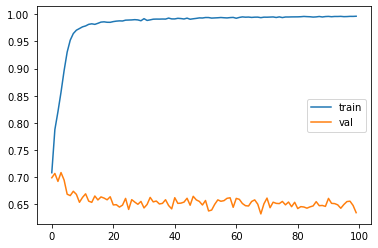

In [6]:
# Fit a basic fully-connected network to the top 2150 HVGs
df = pd.read_csv(annotfiles_train[0], header=0, index_col=0, sep='\t')
annot_names = list(df.index.values)

spot_clf_hvg = nn.Sequential(
    nn.Linear(len(hvgs), 500),
    nn.Linear(500, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    
    nn.Linear(100, 100),
    nn.Linear(100, 50),
    nn.BatchNorm1d(50),
    nn.ReLU(),
    
    nn.Linear(50, len(annot_names))
)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(spot_clf_hvg.parameters(), lr=1e-4)

spot_clf_hvg, val_hist, train_hist = train_spotwise(spot_clf_hvg, dataloader_spot_hvg, loss, optimizer, 100, 
                                                    display=False, outfile='../models/spot_classifier_hvg.pth')

fig = plt.figure()
plt.plot(train_hist, label='train')
plt.plot(val_hist, label='val')
plt.legend()